In [1]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

from matplotlib.colors import ListedColormap
from pandas.plotting import scatter_matrix

from sklearn.compose import ColumnTransformer
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, accuracy_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

plt.rcParams['figure.figsize'] = (16, 12)

This data came from [kaggle](https://www.kaggle.com/datasets/pablomonleon/tour-de-france-historic-stages-data), but the times in the `stage_data.csv` file were all broken. I've gone back to the [original R package](https://github.com/alastairrushworth/tdf) and fixed things up.

In [3]:
riderDF = pd.read_csv(
    'https://m2pi.syzygy.ca/data/tdf/stage_data_timed.csv',
    na_values={'rank': 'DNF'},
)
winnerDF = pd.read_csv(
    'https://m2pi.syzygy.ca/data/tdf/tdf_winners.csv',
    parse_dates=['start_date'],
)
stageDF = pd.read_csv(
    'https://m2pi.syzygy.ca/data/tdf/tdf_stages.csv',
    parse_dates=['Date'],
)
stageDF.columns = stageDF.columns.str.strip().str.lower()

## What do we have?

Poke around with `.info`, `.describe`, `.columns`, `.head` to see what the data looks like. 

In [4]:
stageDF.tail(n=5)

,stage,date,distance,origin,destination,type,winner,winner_country
2231,2,1903-07-05,374.0,Lyon,Marseille,Stage with mountain(s),Hippolyte Aucouturier,FRA
2232,3,1903-07-08,423.0,Marseille,Toulouse,Plain stage,Hippolyte Aucouturier,FRA
2233,4,1903-07-12,268.0,Toulouse,Bordeaux,Plain stage,Charles Laeser,SUI
2234,5,1903-07-13,425.0,Bordeaux,Nantes,Plain stage,Maurice Garin,FRA
2235,6,1903-07-18,471.0,Nantes,Paris,Plain stage,Maurice Garin,FRA


In [5]:
riderDF.head()

,year,stage,rank,rider,age,team,points,elapsed
0,1903,stage-1,1,Garin Maurice,32.0,NaN,100.0,63913.0
1,1903,stage-1,2,Pagie Émile,32.0,NaN,70.0,63968.0
2,1903,stage-1,3,Georget Léon,23.0,NaN,50.0,66012.0
3,1903,stage-1,4,Augereau Fernand,20.0,NaN,40.0,67681.0
4,1903,stage-1,5,Fischer Jean,36.0,NaN,32.0,67806.0


In [6]:
winnerDF.head(n=3)

,edition,start_date,winner_name,winner_team,distance,time_overall,time_margin,stage_wins,stages_led,height,weight,age,born,died,full_name,nickname,birth_town,birth_country,nationality
0,1,1903-07-01,Maurice Garin,La Française,2428.0,94.553889,2.989167,3,6,1.62,60.0,32,1871-03-03,1957-02-19,NaN,The Little Chimney-sweep,Arvier,Italy,France
1,2,1904-07-02,Henri Cornet,Conte,2428.0,96.098611,2.270556,1,3,NaN,NaN,19,1884-08-04,1941-03-18,NaN,Le rigolo (The joker),Desvres,France,France
2,3,1905-07-09,Louis Trousselier,Peugeot–Wolber,2994.0,NaN,NaN,5,10,NaN,NaN,24,1881-06-29,1939-04-24,NaN,Levaloy / Trou-trou,Paris,France,France


## Some Basic Questions

 * How has the distance of the race changed over the years
 * How has the distance of the stages changed over the years
 * How have the riders changed over the years (e.g. age)
 * How have the winning margins changed over the years

Text(0.5, 1.0, 'Total distance by year')

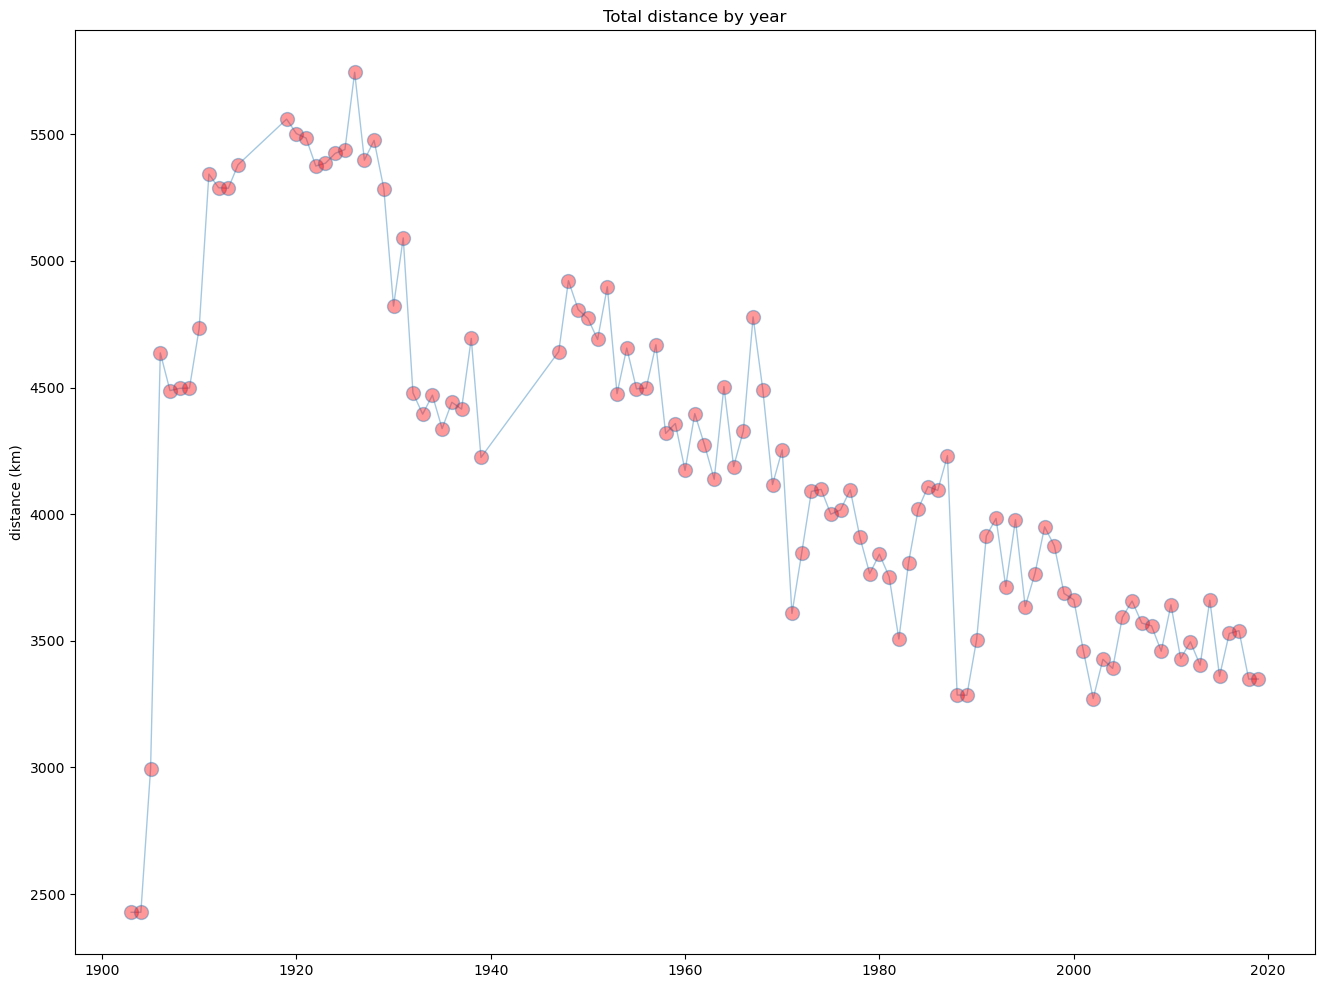

In [7]:
fig, ax = plt.subplots()

ax.plot(
    winnerDF.start_date.dt.year, 
    winnerDF.distance,
    linestyle='-',
    linewidth=1,
    marker='o',
    markersize=10,
    markerfacecolor='red',
    alpha=0.4
)
ax.set_ylabel('distance (km)')
ax.set_title('Total distance by year')

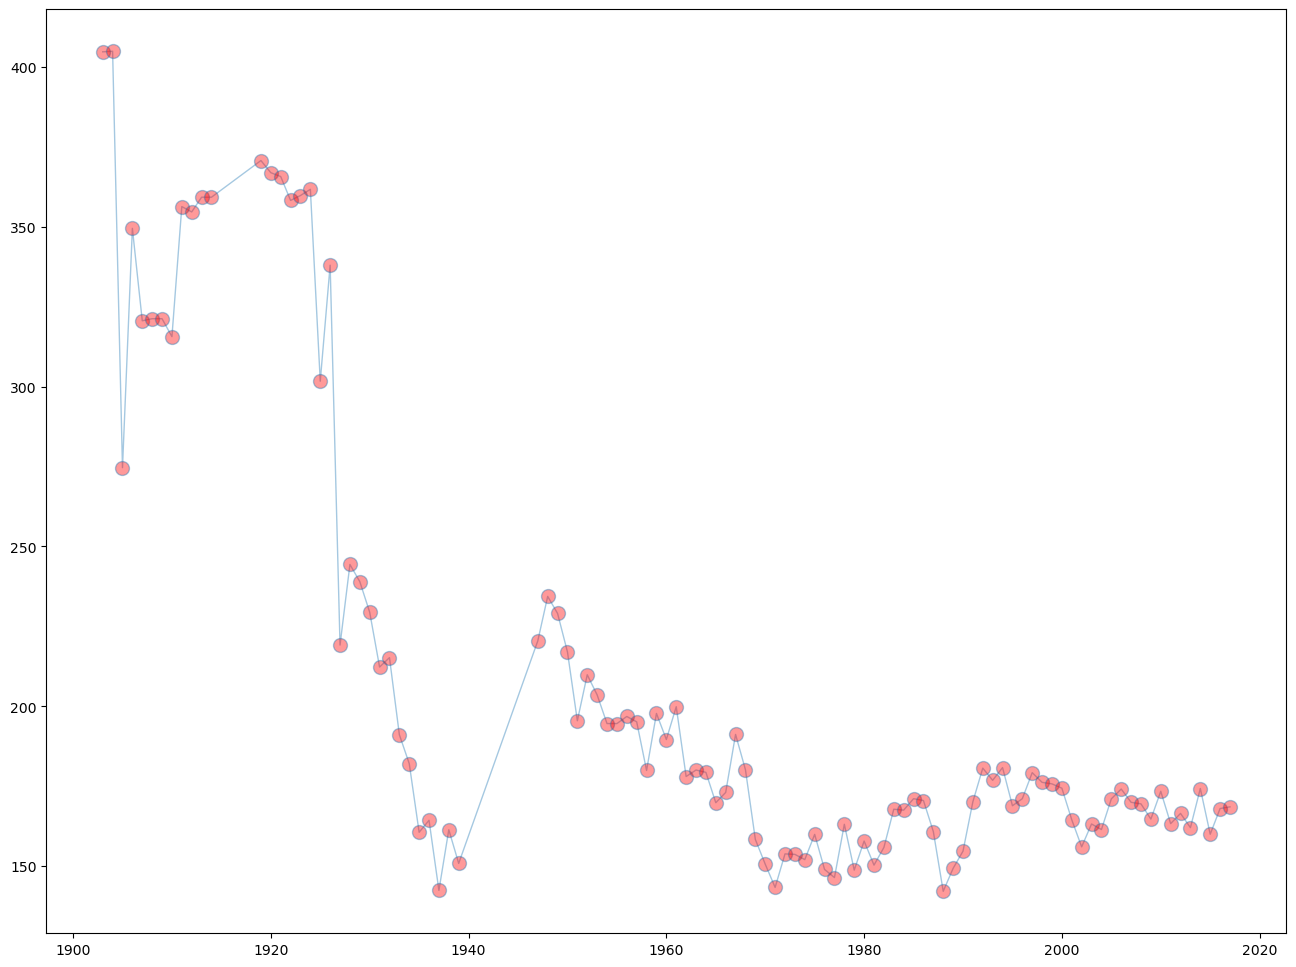

In [8]:
stages = stageDF.groupby(stageDF.date.dt.year).distance.mean()
fig, ax = plt.subplots()

ax.plot(
    stages,
    linestyle='-',
    linewidth=1,
    marker='o',
    markersize=10,
    markerfacecolor='red',
    alpha=0.4
)

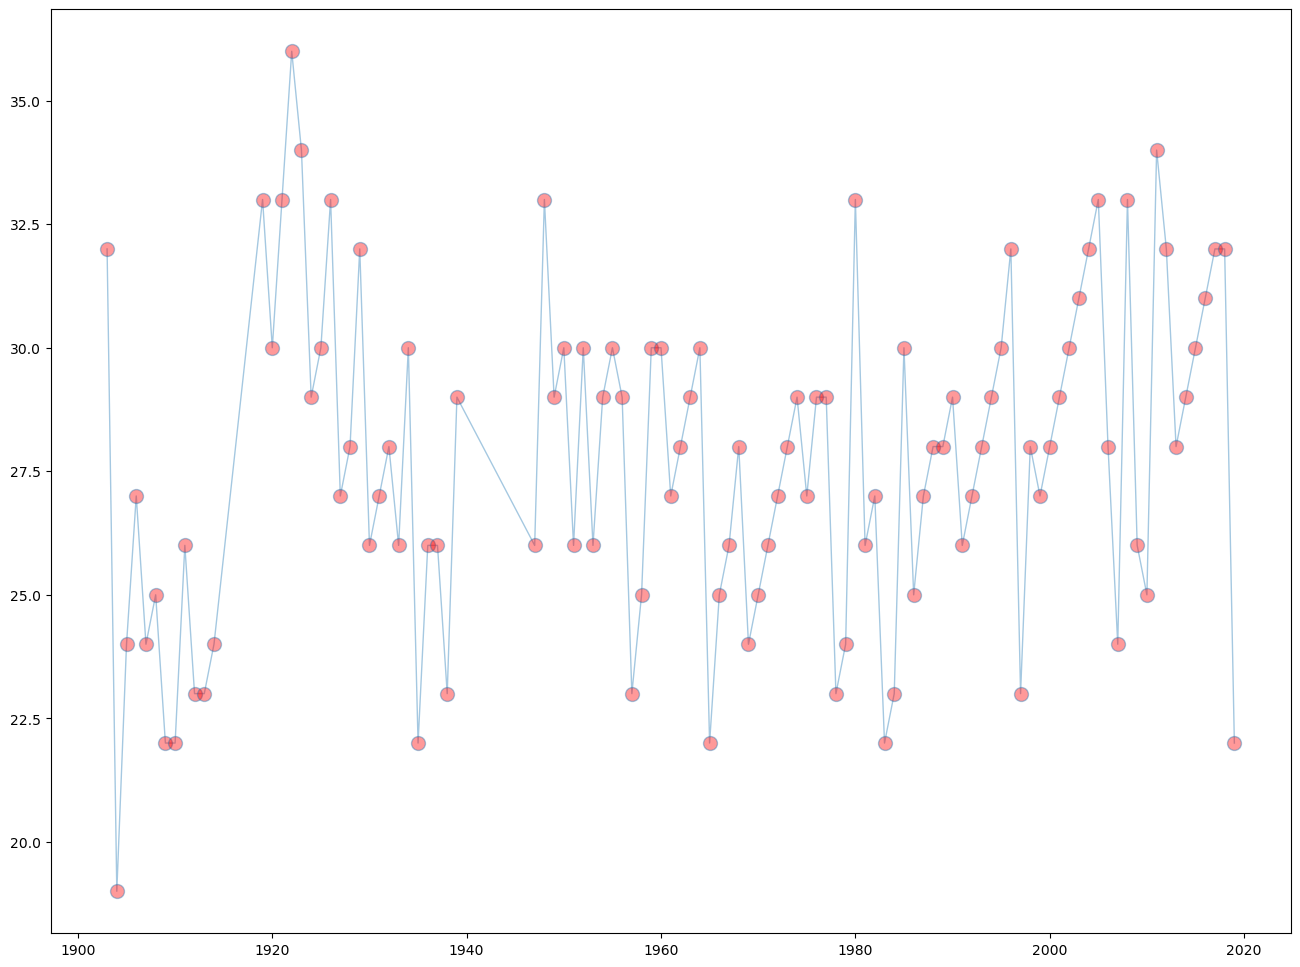

In [9]:
fig, ax = plt.subplots()
ax.plot(
    winnerDF.start_date.dt.year,
    winnerDF.age,
    linestyle='-',
    linewidth=1,
    marker='o',
    markersize=10,
    markerfacecolor='red',
    alpha=0.4
)

<Axes: xlabel='year'>

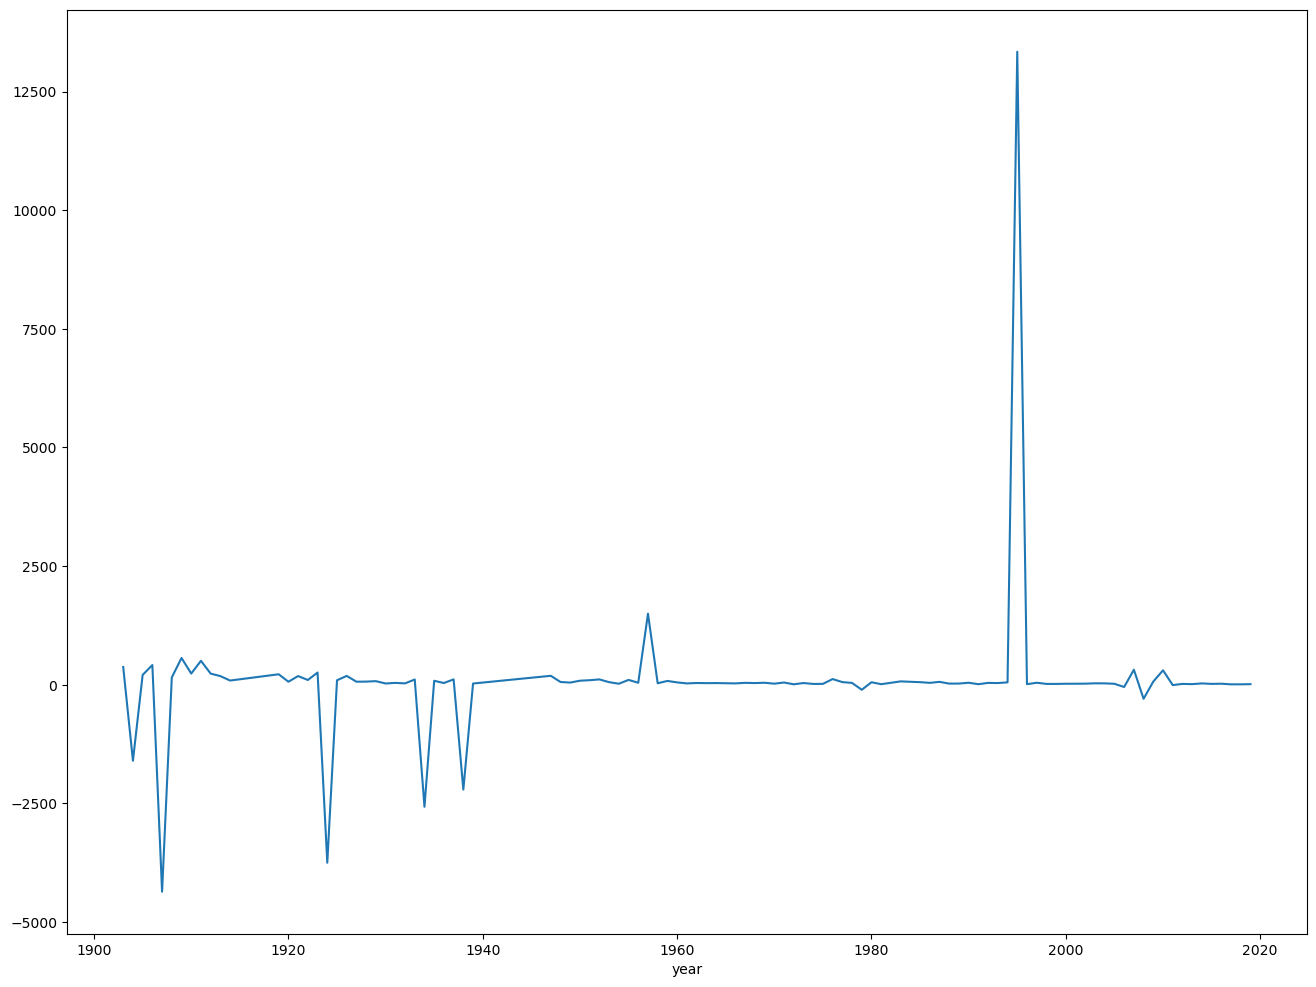

In [11]:
stage_first_times = riderDF[riderDF['rank'] == '1'].groupby('year').elapsed.mean()
stage_second_times = riderDF[riderDF['rank'] == '2'].groupby('year').elapsed.mean()
(stage_second_times - stage_first_times).plot()

Those should all be positive! I've probably still got mistakes in the `elapsed` feature somewhere

### Cleaning Up and Building Some Extra Features

For `winnerDF` we have height and weight which would give us `BMI`, crude, but it might be useful

In [12]:
winnerDF['BMI'] = winnerDF['weight'] / winnerDF['height']**2

In [13]:
stageDF.type.value_counts()

Plain stage                      1053
Stage with mountain(s)            530
Individual time trial             205
Flat stage                        110
Team time trial                    87
Hilly stage                        76
High mountain stage                43
Mountain stage                     40
Medium mountain stage              33
Mountain time trial                13
Stage with mountain                11
Mountain Stage                     11
Flat Stage                          9
Half Stage                          5
Transition stage                    4
Intermediate stage                  3
Flat cobblestone stage              2
Plain stage with cobblestones       1
Name: type, dtype: int64

In [14]:
stageDF.groupby('type').distance.mean()

type
Flat Stage                       202.222222
Flat cobblestone stage           234.000000
Flat stage                       189.609091
Half Stage                       102.800000
High mountain stage              172.174419
Hilly stage                      196.328947
Individual time trial             39.111098
Intermediate stage               183.166667
Medium mountain stage            185.303030
Mountain Stage                   193.727273
Mountain stage                   190.912500
Mountain time trial               45.338462
Plain stage                      226.270940
Plain stage with cobblestones    224.000000
Stage with mountain              337.818182
Stage with mountain(s)           220.900189
Team time trial                  103.278161
Transition stage                 179.625000
Name: distance, dtype: float64

There's a bit too much variation, so we could try classifying these stages ourselves, e.g.

In [16]:
stage_types = {
    'Flat' : [
        'Plain stage',
        'Flat stage',
        'Flat Stage',
        'Transition stage',
        'Intermediate stage',
        'Flat cobblestone stage',
        'Plain stage with cobblestones',
        'Half Stage',
    ],
    'Mountain' : [
        'High mountain stage',
        'Mountain stage',
        'Mountain Stage',
        'Medium mountain stage',
        'Stage with mountain',
        'Stage with mountain(s)',
    ],
    'Hilly' : [
        'Hilly stage',
    ],
    'TimeTrial' : [
        'Individual time trial',
        'Mountain time trial',
        'Team time trial',
    ],
}

In [19]:
for stage_type, variations in stage_types.items():
    stageDF.loc[stageDF.type.isin(variations), 'type'] = stage_type

stageDF['category'] = stageDF.type.astype("category")

Comparing the `DataFrames`, there are some opportunities to join columns to provide richer information. There are also some manipulations we could try to build other features to explore

In [20]:
stageDF['year'] =  stageDF.date.dt.year

In [21]:
riderDF['stage'] = riderDF.stage.str.replace('stage-','')

In [22]:
cDF = riderDF.merge(stageDF, left_on=['year', 'stage'], right_on=['year', 'stage'])
cDF.head()

,year,stage,rank,rider,age,team,points,elapsed,date,distance,origin,destination,type,winner,winner_country,category
0,1903,1,1,Garin Maurice,32.0,NaN,100.0,63913.0,1903-07-01,467.0,Paris,Lyon,Flat,Maurice Garin,FRA,Flat
1,1903,1,2,Pagie Émile,32.0,NaN,70.0,63968.0,1903-07-01,467.0,Paris,Lyon,Flat,Maurice Garin,FRA,Flat
2,1903,1,3,Georget Léon,23.0,NaN,50.0,66012.0,1903-07-01,467.0,Paris,Lyon,Flat,Maurice Garin,FRA,Flat
3,1903,1,4,Augereau Fernand,20.0,NaN,40.0,67681.0,1903-07-01,467.0,Paris,Lyon,Flat,Maurice Garin,FRA,Flat
4,1903,1,5,Fischer Jean,36.0,NaN,32.0,67806.0,1903-07-01,467.0,Paris,Lyon,Flat,Maurice Garin,FRA,Flat


In [23]:
cDF['speed'] = cDF['distance'] / (cDF['elapsed'] / 3600)

In [25]:
cDF.speed.describe()

count    236462.000000
mean         36.748927
std          28.198454
min           0.199792
25%          31.300161
50%          36.596786
75%          40.898960
max         790.866142
Name: speed, dtype: float64

790 km/h seems quite high, even for the 1990s-2000s

<Axes: >

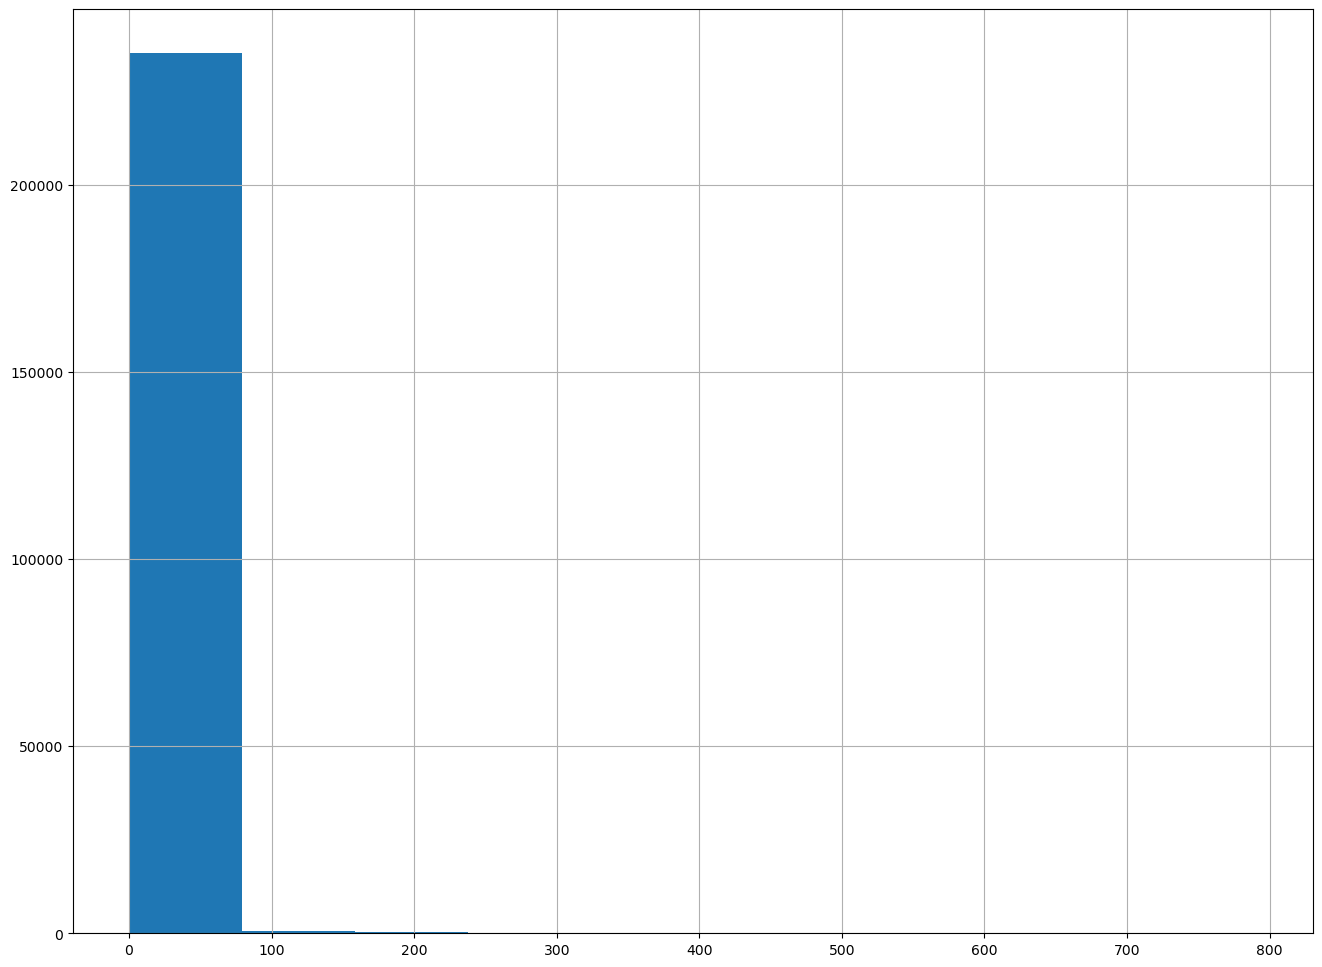

In [26]:
cDF.speed.hist()

In [28]:
cDF.loc[cDF.speed > 60]

,year,stage,rank,rider,age,team,points,elapsed,date,distance,origin,destination,type,winner,winner_country,category,speed
33377,1937,18b,1,Lapebie Roger,26.0,France,100.0,7150.0,1937-07-23,172.0,La Roche-sur-Yon,Rennes,Flat,Paul Chocque,FRA,Flat,86.601399
33378,1937,18b,2,Marcaillou Sylvain,26.0,France,70.0,7150.0,1937-07-23,172.0,La Roche-sur-Yon,Rennes,Flat,Paul Chocque,FRA,Flat,86.601399
33379,1937,18b,3,Chocque Paul,27.0,France,50.0,7150.0,1937-07-23,172.0,La Roche-sur-Yon,Rennes,Flat,Paul Chocque,FRA,Flat,86.601399
33380,1937,18b,4,Tanneveau Robert,25.0,France,40.0,7150.0,1937-07-23,172.0,La Roche-sur-Yon,Rennes,Flat,Paul Chocque,FRA,Flat,86.601399
33381,1937,18b,5,Martano Giuseppe,27.0,Italy,32.0,7161.0,1937-07-23,172.0,La Roche-sur-Yon,Rennes,Flat,Paul Chocque,FRA,Flat,86.468370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108447,1977,22b,50,Julien Ferdinand,31.0,Lejeune - BP,NaN,529.0,1977-07-24,91.0,Paris,Paris,Flat,Alain Meslet,FRA,Flat,619.281664
108448,1977,22b,51,Bourreau Bernard,25.0,Peugeot - Esso - Michelin,NaN,530.0,1977-07-24,91.0,Paris,Paris,Flat,Alain Meslet,FRA,Flat,618.113208
108449,1977,22b,52,Karstens Gerben,35.0,TI-Raleigh,NaN,531.0,1977-07-24,91.0,Paris,Paris,Flat,Alain Meslet,FRA,Flat,616.949153
108450,1977,22b,53,Le Denmat Michel,26.0,Lejeune - BP,NaN,533.0,1977-07-24,91.0,Paris,Paris,Flat,Alain Meslet,FRA,Flat,614.634146


In [29]:
cDF[cDF.speed > 60].distance.value_counts()

89.0     175
223.0    141
91.0     141
137.5    132
90.0     130
150.5    117
139.5    115
125.0    113
137.0    113
151.0     96
76.0      96
160.0     95
171.0     90
119.0     79
249.0     69
172.0     46
Name: distance, dtype: int64

Looks plausible and a quick check on wikipedia says that 1937 stage 18b time was ~6hours so it's probably the elapsed time which is wrong. We will discard that information for the entries identified above

In [30]:
cDF.loc[cDF.elapsed > 200000, 'elapsed'] = np.nan
cDF.loc[cDF.speed > 60, ['elapsed', 'speed']] =  np.nan

In [31]:
cDF.loc[(cDF.year == 2015) & (cDF.stage == '9')  & (cDF.elapsed > 100000), ['elapsed', 'speed']] = np.nan # Gibberish
cDF.loc[(cDF.year == 1995) & (cDF.stage == '16') & (cDF.elapsed > 100000), ['elapsed', 'speed']] = np.nan # Cancelled
cDF.loc[(cDF.year == 1982) & (cDF.stage == '9a') & (cDF.elapsed > 100000), ['elapsed', 'speed']] = np.nan # Gibberish
cDF.loc[(cDF.year == 1982) & (cDF.stage == '9b') & (cDF.elapsed > 100000), ['elapsed', 'speed']] = np.nan # Don't believe it
cDF.loc[(cDF.year == 1980) & (cDF.stage == '7a') & (cDF.elapsed > 100000), ['elapsed', 'speed']] = np.nan # Don't believe it
cDF.loc[(cDF.year == 1980) & (cDF.stage == '7b') & (cDF.elapsed > 100000), ['elapsed', 'speed']] = np.nan # Don't believe it
cDF.loc[(cDF.year == 1979) & (cDF.stage == '8') & (cDF.elapsed > 100000), ['elapsed', 'speed']] = np.nan # Nope
cDF.loc[(cDF.year == 1924) & (cDF.stage == '3') & (cDF.elapsed > 100000), ['elapsed', 'speed']] = np.nan # Checked the time

<Axes: >

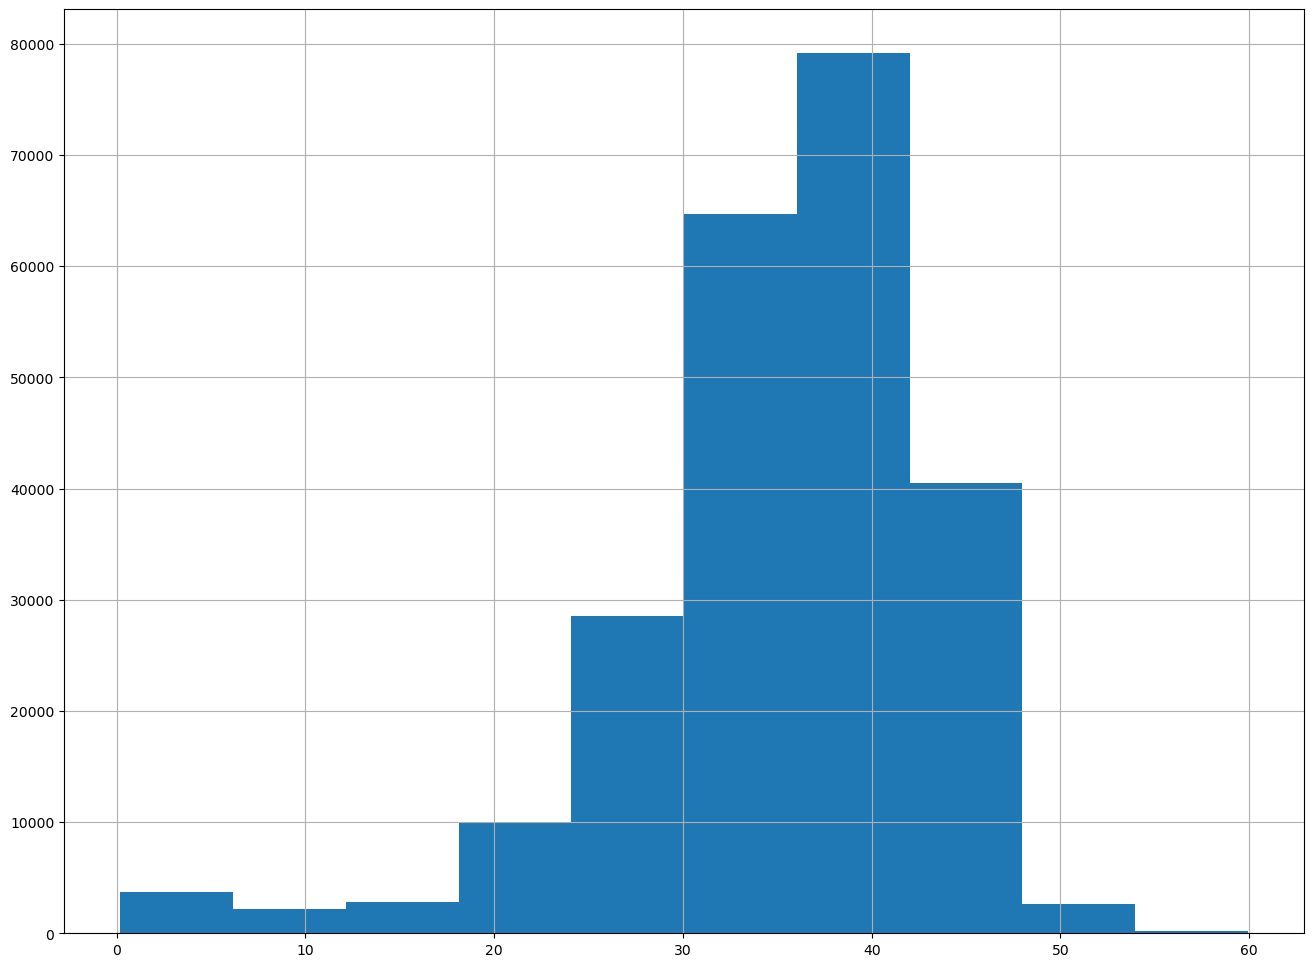

In [32]:
cDF.speed.hist()

That looks a bit more sane

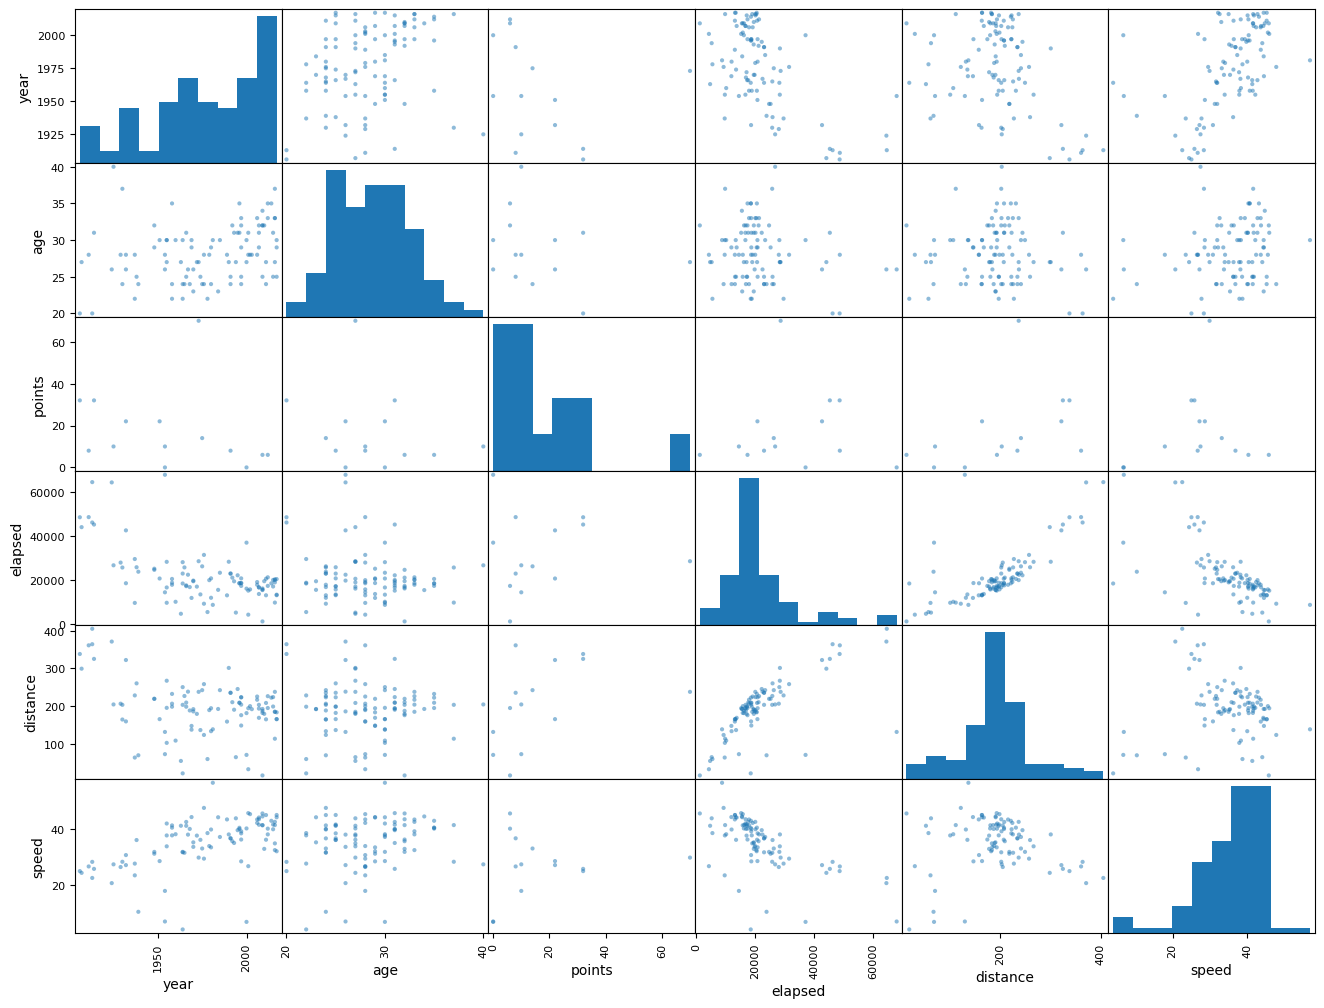

In [33]:
from pandas.plotting import scatter_matrix
scatter_matrix(cDF.sample(100));

In [34]:
cDF.head()

,year,stage,rank,rider,age,team,points,elapsed,date,distance,origin,destination,type,winner,winner_country,category,speed
0,1903,1,1,Garin Maurice,32.0,NaN,100.0,63913.0,1903-07-01,467.0,Paris,Lyon,Flat,Maurice Garin,FRA,Flat,26.304508
1,1903,1,2,Pagie Émile,32.0,NaN,70.0,63968.0,1903-07-01,467.0,Paris,Lyon,Flat,Maurice Garin,FRA,Flat,26.281891
2,1903,1,3,Georget Léon,23.0,NaN,50.0,66012.0,1903-07-01,467.0,Paris,Lyon,Flat,Maurice Garin,FRA,Flat,25.468097
3,1903,1,4,Augereau Fernand,20.0,NaN,40.0,67681.0,1903-07-01,467.0,Paris,Lyon,Flat,Maurice Garin,FRA,Flat,24.840059
4,1903,1,5,Fischer Jean,36.0,NaN,32.0,67806.0,1903-07-01,467.0,Paris,Lyon,Flat,Maurice Garin,FRA,Flat,24.794266


In [35]:
cols = [c for c in cDF.columns if cDF[c].dtype in (np.float64, np.int64)]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cDF_scaled = pd.DataFrame(
    scaler.fit_transform(cDF[cols]),
    cDF.index,
    columns=cols
)

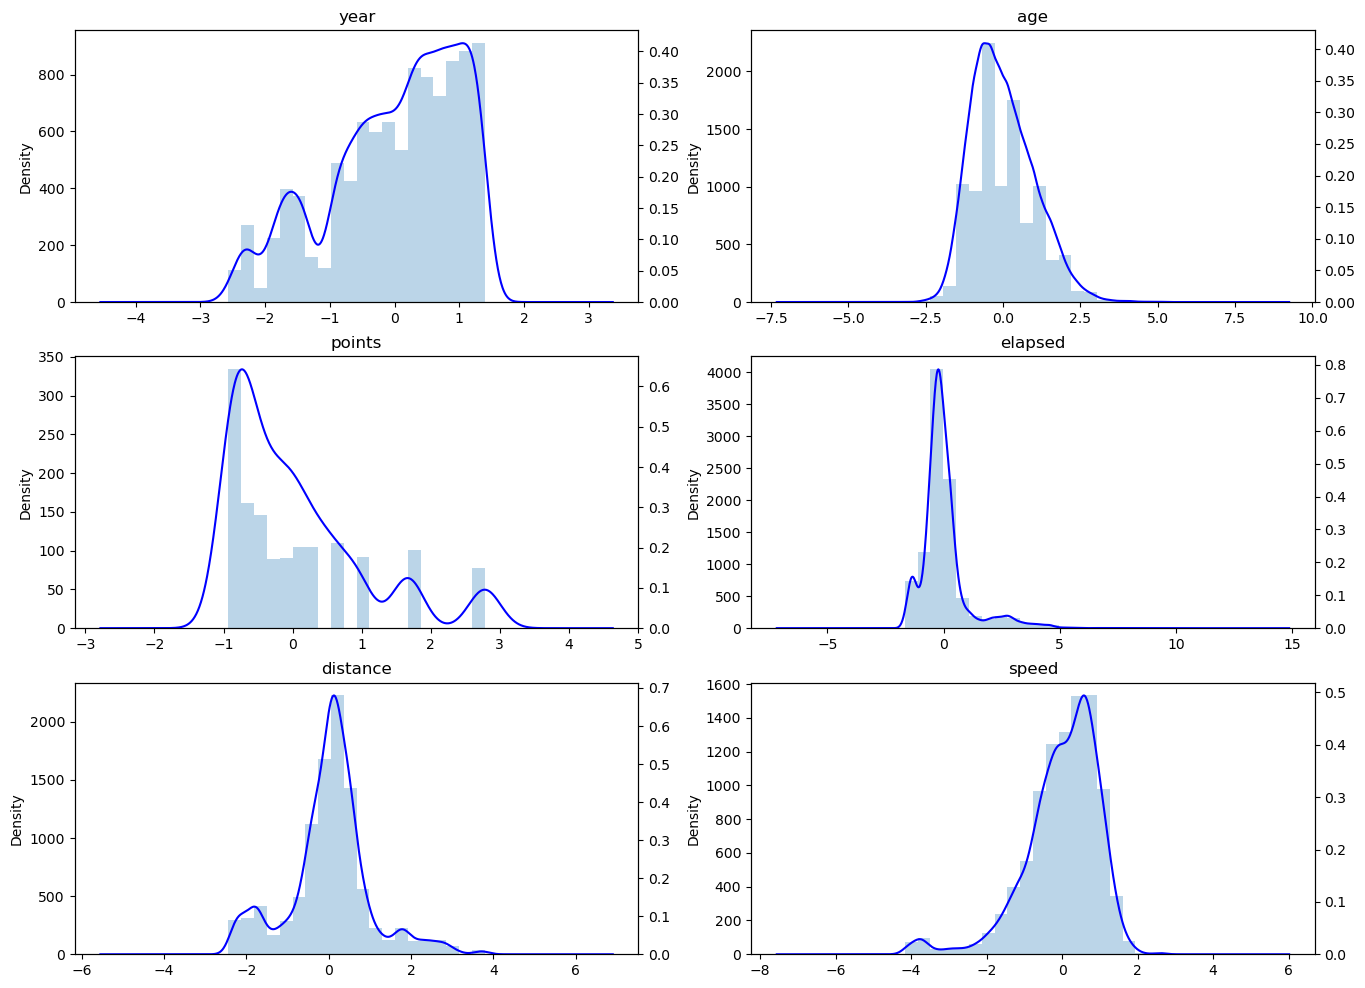

In [36]:
fig, axes = plt.subplots(len(cols) // 2, 2)

_df = cDF_scaled.sample(10000)
for i, feature in enumerate(cols):
    ax = axes[i // 2, i % 2]
    _df[feature].plot.hist(ax = ax, bins=20, alpha=0.3)
    _df[feature].plot.kde(ax = ax, secondary_y=True, color='blue')
    ax.set_ylim(0)
    ax.right_ax.set_ylim(0)
    ax.set_title(feature)

<Axes: xlabel='elapsed', ylabel='Count'>

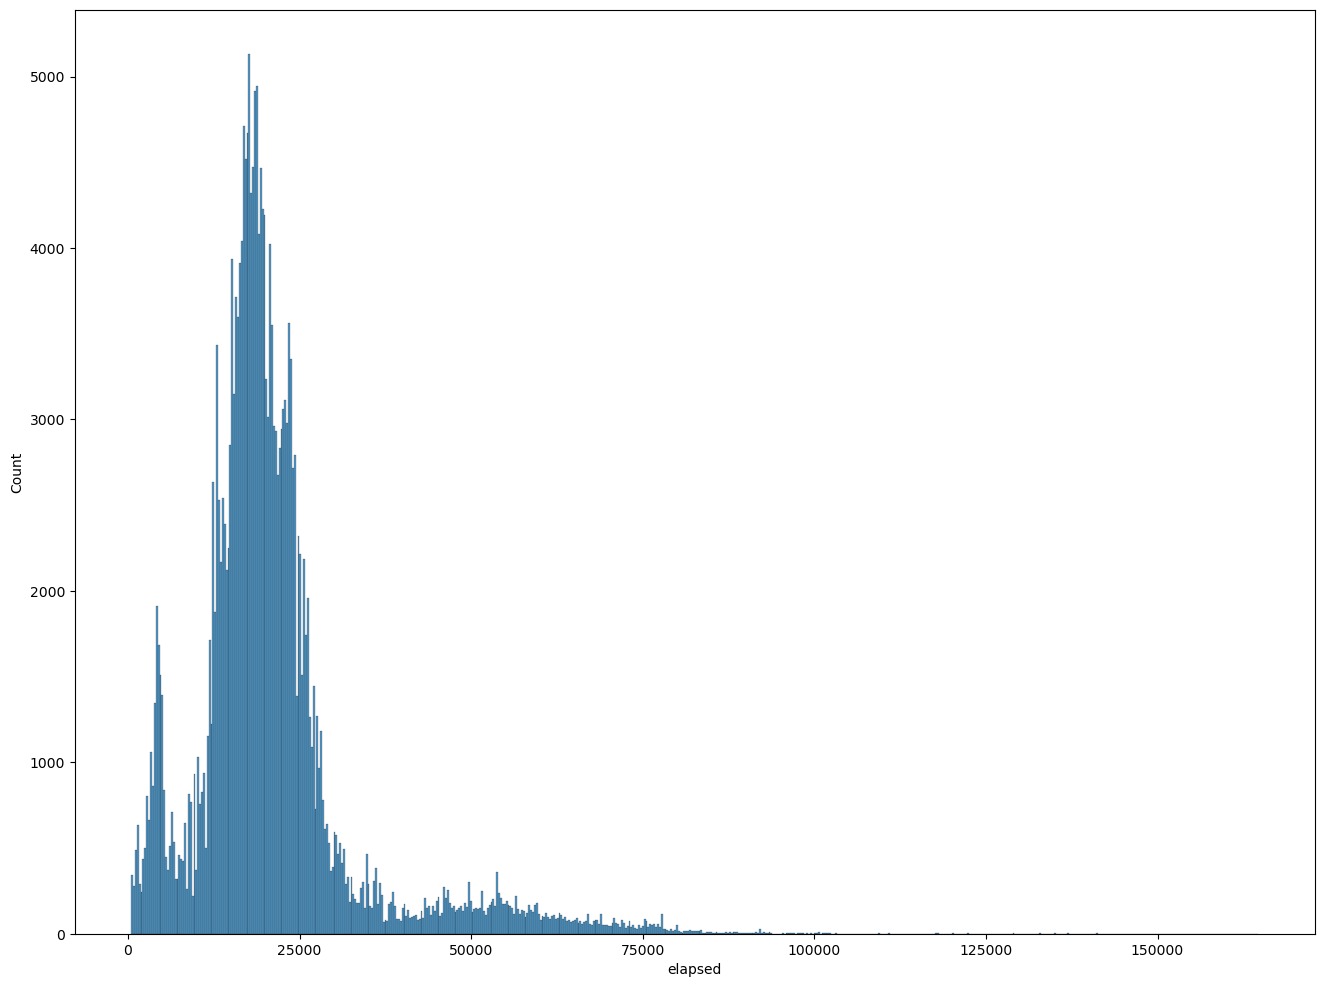

In [37]:

sns.histplot(cDF.elapsed)

`elapsed` is seconds elapsed. In the very early days, there were some really long stages (450km+) but let's assume that anything less than 

## Some possible questions

* Use regression to try to predict the some of the numerical values, e.g.
  * age of the winner
  * speed of the winner
  * the elapsed variable of `cDF`
  * ...
* Try to build a classifier for rider types. Some riders perform better on mountain stages (climbers), others on flat stages (sprinters), see what clusters you can find.


In [38]:
num_cols = [c for c in cDF.columns if cDF[c].dtype in (np.float64, np.int64)]
num_cols.remove('elapsed')
cat_cols = ['type']
cols = num_cols + cat_cols + ['elapsed']

transform = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(), cat_cols)
])

_df = cDF[cols].dropna()

_df_tr = transform.fit_transform(_df)
_df_tr = pd.DataFrame(
    _df_tr,
    columns=transform.get_feature_names_out()
)

In [41]:
X = _df_tr[transform.get_feature_names_out()]
y = _df['elapsed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [42]:
model = LinearRegression().fit(X_train, y_train)

In [43]:
y_train_pred = model.predict(X_train)

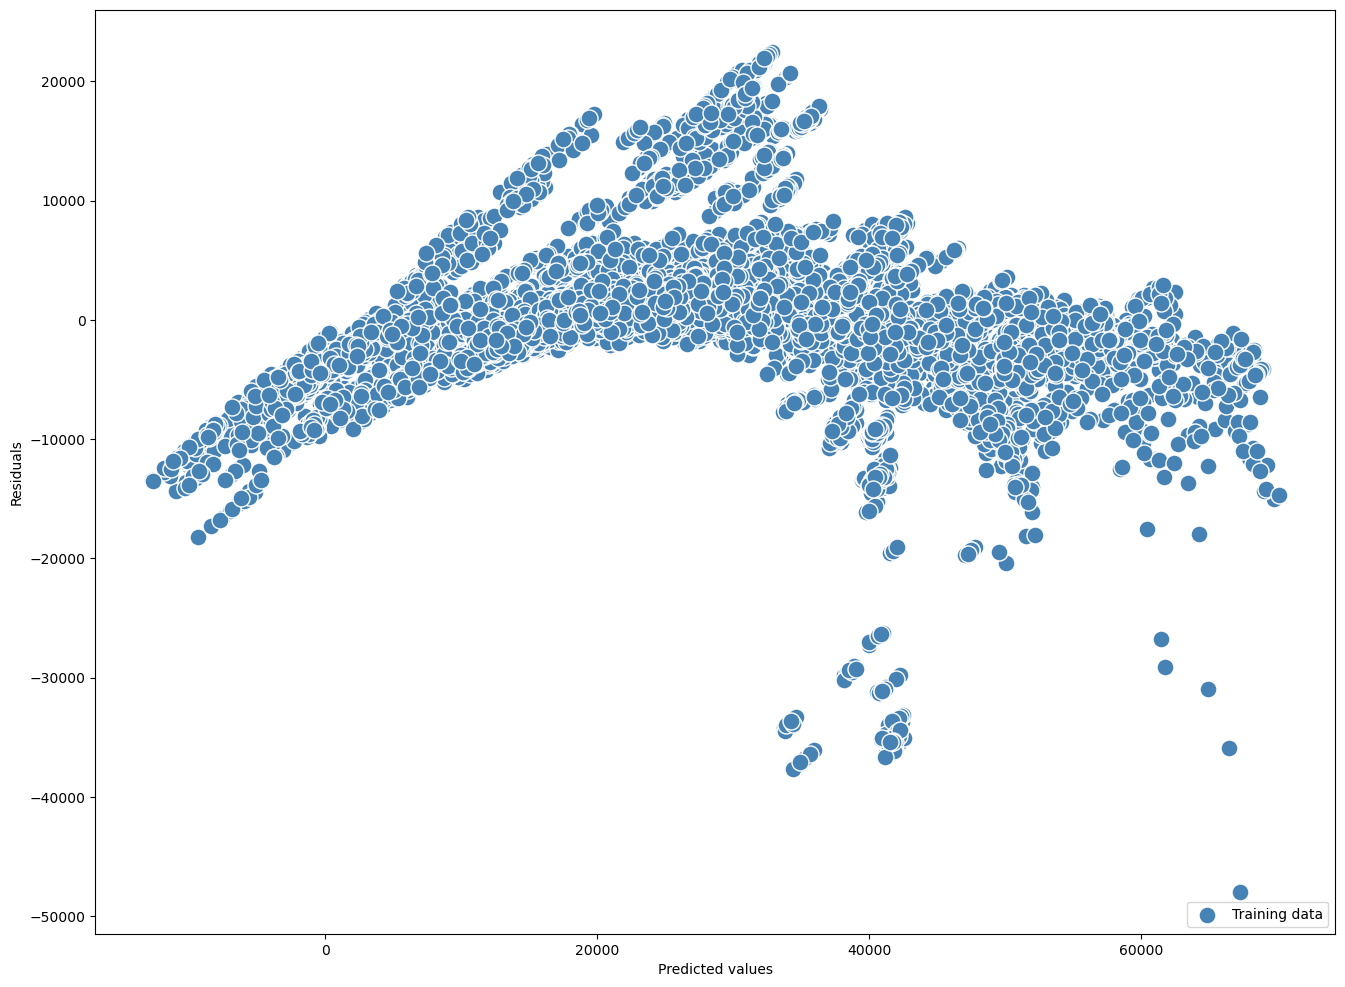

In [44]:
fig,ax = plt.subplots()

ax.scatter(y_train_pred,  y_train_pred - y_train,
            c='steelblue', marker='o', s=150, edgecolor='white',
            label='Training data')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Residuals')
ax.legend(loc='upper left')
ax.legend(loc='lower right')

In [45]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print(f"RMSE train: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.3f}")
print(f"R^2 train: {r2_score(y_train, y_train_pred)}")

RMSE train: 5437.126
R^2 train: 0.8566119475842361


In [46]:
from sklearn.model_selection import cross_val_score

In [48]:
scores = cross_val_score(model, X_train, y_train,
                         scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-scores)

print(f"{lin_rmse_scores.mean()} += {lin_rmse_scores.std()}")

5436.585685337861 += 203.69096827195736


More than an hour, so not great. Looking at the [choosing the right estimator](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) map, we should be in regression section and trying eitehr `Lasso` or `ElasticNet`.

In [49]:
from sklearn.linear_model import Lasso

In [50]:
model_lasso = Lasso(alpha=0.1)

model_lasso.fit(X_train, y_train)
y_train_pred = model_lasso.predict(X_train)

In [51]:
scores = cross_val_score(model_lasso, X_train, y_train,
                         scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-scores)

print(f"{lin_rmse_scores.mean()} += {lin_rmse_scores.std()}")

5436.585188765502 += 203.70217897425877


Nope, I've probably missed something here, but let's just try another tack

### RandomForestRegressor

In [52]:
from sklearn.ensemble import RandomForestRegressor

In [53]:
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)
y_train_pred = model_rf.predict(X_train)

In [54]:
print(f"RMSE train: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.3f}")
print(f"R^2 train: {r2_score(y_train, y_train_pred)}")

RMSE train: 76.549
R^2 train: 0.9999715779839392


I interperate that as being accurate within a few mins which is great, but probably worth being suspicious of. Looking at the residuals above, I probably still have some issues with the value in the `elapsed` column. I should stop and look at them, but we'll move on for now

In [55]:
max_features = ['sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(5, 20, num = 5)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [56]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 8, 12, 16, 20],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   random_state=42, verbose=2)

In [57]:
rf_random.best_params_

{'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 16,
 'bootstrap': False}

In [58]:
model_rf = rf_random.best_estimator_
#model_rf.fit(X_train)
y_test_pred = model_rf.predict(X_test)

In [59]:
print(f"RMSE train: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.3f}")
print(f"R^2 train: {r2_score(y_train, y_train_pred)}")

RMSE train: 426.389
R^2 train: 0.9999715779839392


## Try to classify the stages by type

In [60]:
from sklearn.svm import SVC

num_cols = [c for c in cDF.columns if cDF[c].dtype in (np.float64, np.int64)]
cat_cols = ['type']
cols = num_cols + cat_cols

transform = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
])

_df = cDF[cols].dropna()

_df_tr = transform.fit_transform(_df)
_df_tr = pd.DataFrame(
    _df_tr,
    columns=transform.get_feature_names_out()
)
_df_tr

X = _df_tr[transform.get_feature_names_out()]
y = _df['type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [61]:
model_svc = SVC(kernel='linear')
model_svc.fit(X_train, y_train)

SVC(kernel='linear')

In [62]:
y_train_pred = model_svc.predict(X_train)
accuracy_score(y_train, y_train_pred)

0.753333049367466

That isn't bad without any tuning

<Axes: >

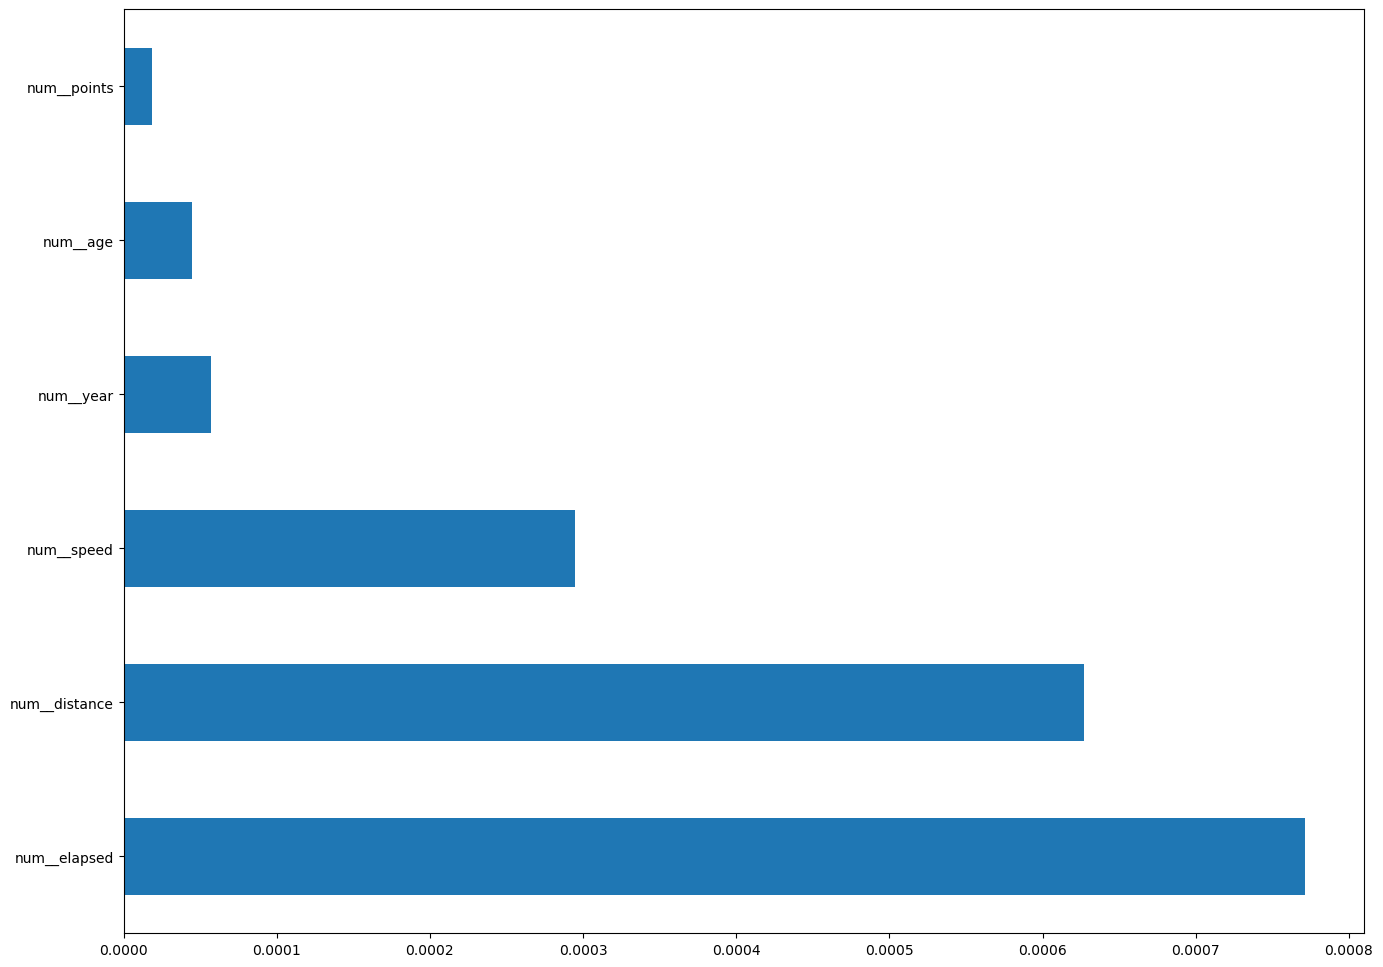

In [63]:
pd.Series(abs(model_svc.coef_[0]), index=model_svc.feature_names_in_).nlargest(10).plot(kind='barh')

So seconds elapsed and distance are the most important features, but they're going to be strongly correlated. Let's visualize the classification according to speed and distance

In [64]:
X_train_2 = X_train.loc[:, ['num__speed', 'num__elapsed']]
model_svc2 = SVC(kernel='linear')
model_svc2.fit(X_train_2, y_train)
#fig, ax = plt.subplots()

SVC(kernel='linear')

In [65]:
cy =y_train.astype("category").cat.codes
cy

76298     2
8142      0
8149      0
57082     2
51608     3
         ..
6894      0
147000    2
81757     2
170760    0
6924      0
Length: 23477, dtype: int8

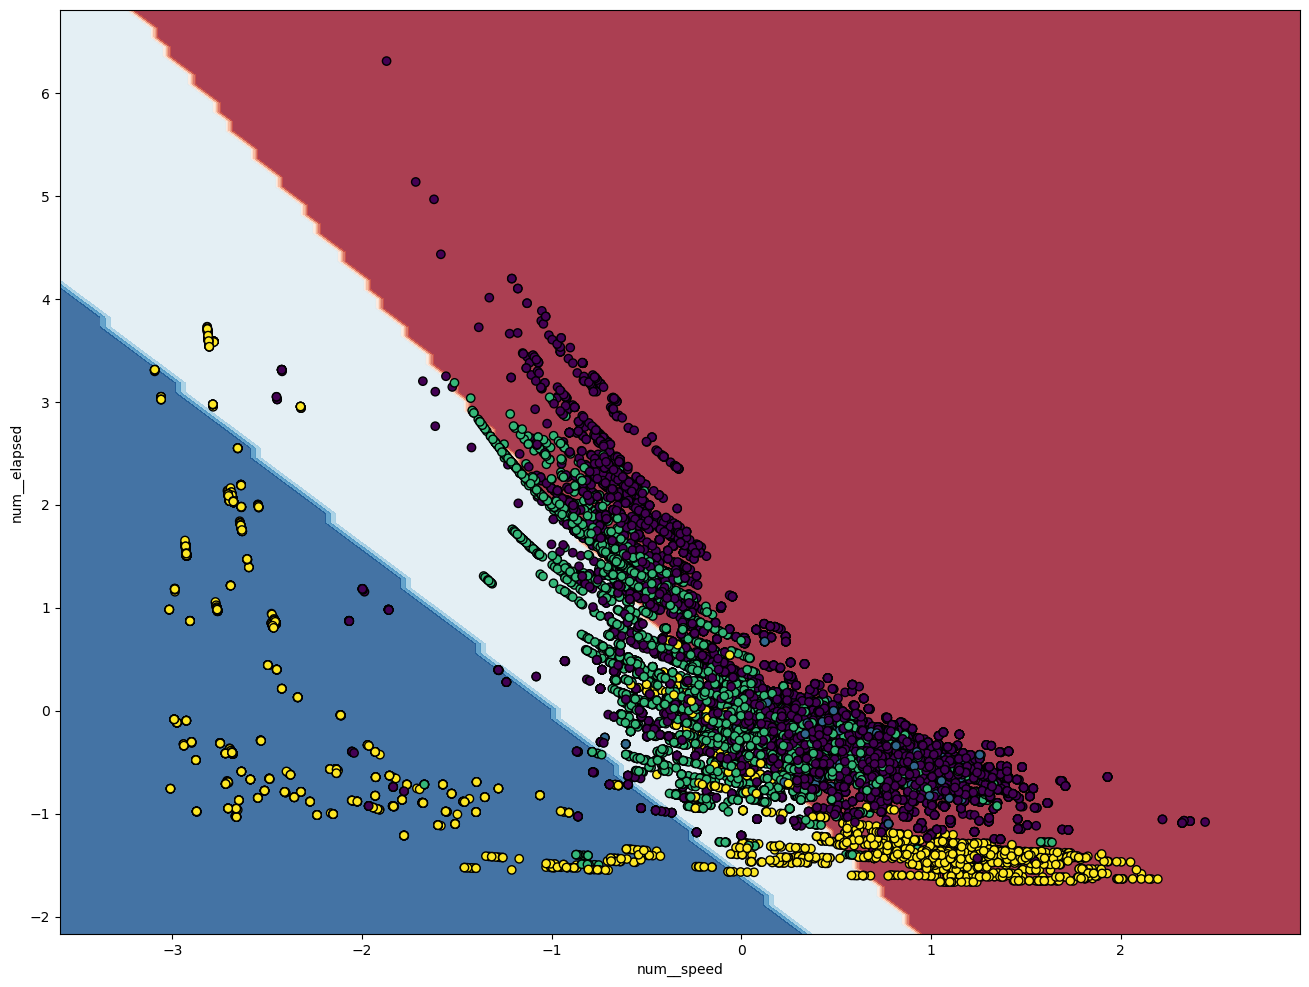

In [66]:
fig, ax = plt.subplots()
DecisionBoundaryDisplay.from_estimator(model_svc2, X_train_2, cmap=plt.cm.RdBu, alpha=0.8, ax=ax, eps=0.5)
ax.scatter(
            X_train_2.iloc[:, 0], X_train_2.iloc[:, 1], c=cy, edgecolors="k"
)

### Try with KNeighborsClassifier

In [67]:
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

KNeighborsClassifier()

In [68]:
y_train_pred = model_knn.predict(X_train)
accuracy_score(y_train, y_train_pred)

0.8419303999659241

[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   1.4s
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   1.4s
[CV] END bootstrap=True, max_depth=12, max_features=sqrt, min_samples_leaf=4, min_samples_split=2; total time=   2.1s
[CV] END bootstrap=False, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   3.9s
[CV] END bootstrap=False, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=2; total time=   3.8s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2; total time=   2.4s
[CV] END bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   3.5s
[CV] END bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2; total time=   1.0s
[CV] END bootstrap=True, max_depth=5, max_features=log2,

A fair bit better, probably worth trying to set some hyperparameters

In [69]:
param_dist = {
    'n_neighbors': range(1, 31),
    'weights': ['uniform', 'distance'],
}

In [70]:
knn = KNeighborsClassifier()
rand = RandomizedSearchCV(knn, param_dist, cv=10, scoring='accuracy', n_iter=10, random_state=5)
rand.fit(X_train, y_train)


RandomizedSearchCV(cv=10, estimator=KNeighborsClassifier(),
                   param_distributions={'n_neighbors': range(1, 31),
                                        'weights': ['uniform', 'distance']},
                   random_state=5, scoring='accuracy')

In [71]:
rand.best_score_

0.7882610843230947

In [72]:
model_knn = rand.best_estimator_
y_train_pred = model_knn.predict(X_train)
accuracy_score(y_train, y_train_pred)

1.0

In [73]:
model_knn_2 = KNeighborsClassifier(n_neighbors=16)
model_knn_2.fit(X_train_2, y_train)

KNeighborsClassifier(n_neighbors=16)

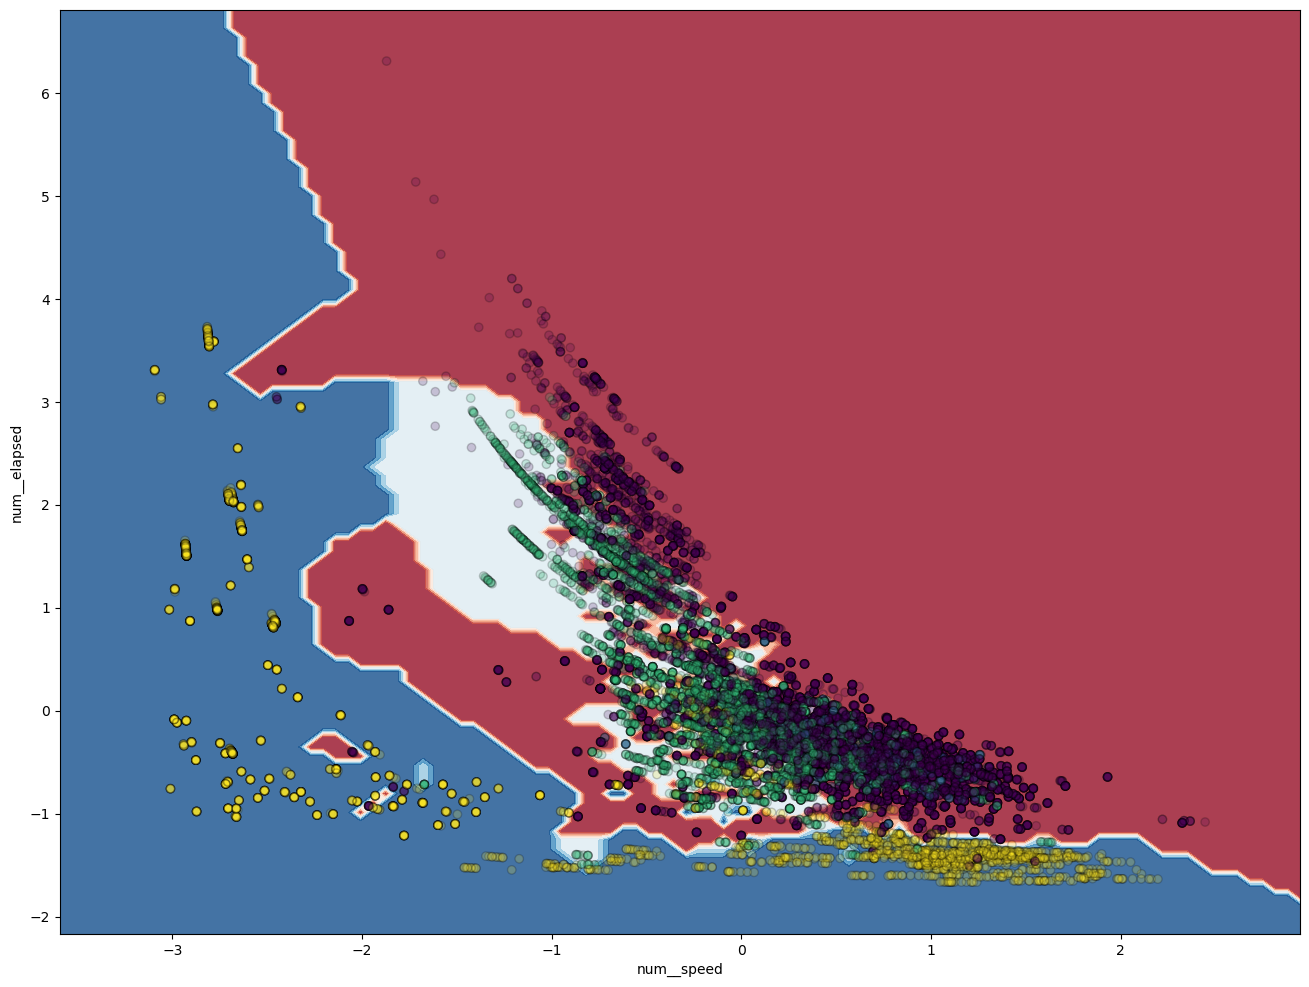

In [74]:
fig, ax = plt.subplots()
DecisionBoundaryDisplay.from_estimator(model_knn_2, X_train_2, cmap=plt.cm.RdBu, alpha=0.8, ax=ax, eps=0.5)
ax.scatter(
            X_train_2.iloc[:, 0], X_train_2.iloc[:, 1], c=cy, edgecolors="k", alpha=0.2
)

## Other bits and pieces

In [ ]:
cDF.head()

In [ ]:
stage_first_times = cDF.loc[cDF['rank'] == '1',['year', 'stage', 'elapsed']]
stage_second_times = cDF.loc[cDF['rank'] == '2', ['year', 'stage', 'elapsed']]
stage_first_times

In [ ]:
_df = stage_first_times.merge(
    stage_second_times,
    left_on=['year', 'stage'],
    right_on=['year', 'stage'],
    suffixes=['_1', '_2'],
)
_df

In [ ]:
(_df.elapsed_2 - _df.elapsed_1).plot()

So there are probably still some mistakes in the elapsed time results, but we'll carry on for now. At some point you should go back and find out what is wrong

In [ ]:
_df = _df.drop(
    _df.index[
        ((_df.elapsed_2 - _df.elapsed_1)>5000) | ((_df.elapsed_2 - _df.elapsed_1) < 0)
    ]
)
(_df.elapsed_2 - _df.elapsed_1).plot()

In [ ]:
_df.index[((_df.elapsed_2 - _df.elapsed_1)>5000)]